In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from astropy.time import Time
from astropy.table import Table
from nuztfpaper.style import output_folder, big_fontsize, base_width, base_height, dpi, data_dir, plot_dir
import seaborn as sns

In [2]:
path = os.path.join(data_dir, "ZTF20abbpkpa_20200606_NOT_v1.ascii")

In [3]:
# redshift = 1. + 0.02846 
# redshift = 1. + 0.033

In [4]:
# data = pd.read_table(path, names=["wl", "flux", "sky_flux", "flux_unc", "xpixel", "ypixel", "response", "flag"], sep="\s+", comment='#')

data = pd.read_table(path, names=["wl", "flux"], sep="\s+", comment='#')


mask = data["flux"] > 0.
data["flux"][~mask] = 0.00

comp = pd.read_table(os.path.join(data_dir, '2005cs_2005-07-02_00-00-00_Ekar_AFOSC_None.dat'), names=["wl", "flux"], sep="\s+", comment='#')

comp_redshift = 1. + 0.002

# dat = Table.read('data/spec-0391-51782-0220.fits', format='fits')
# sdss = dat.to_pandas()
# print(sdss)
# sdss = pd.read_table('data/spec-0391-51782-0001.fits')

In [5]:
smooth = 12

f = np.array(list(data["flux"]))
sf = np.zeros(len(f) - smooth)
swl = np.zeros(len(f) - smooth)

for i in range(smooth):
    sf += np.array(list(f)[i:-smooth+i])
    swl += np.array(list(data["wl"])[i:-smooth+i])
    
sf /= float(smooth)
swl /= float(smooth)

# sdss_smooth = 10

# sdssf = np.array(list(sdss["flux"]))
# ssf = np.zeros(len(sdssf) - sdss_smooth)
# sswl = np.zeros(len(sdssf) - sdss_smooth)

# for i in range(sdss_smooth):
#     ssf += np.array(list(sdssf)[i:-sdss_smooth+i])
#     sswl += np.array(list(10.**sdss["loglam"])[i:-sdss_smooth+i])
    
# ssf /= float(sdss_smooth)
# sswl /= float(sdss_smooth)


NameError: name 'redshift' is not defined

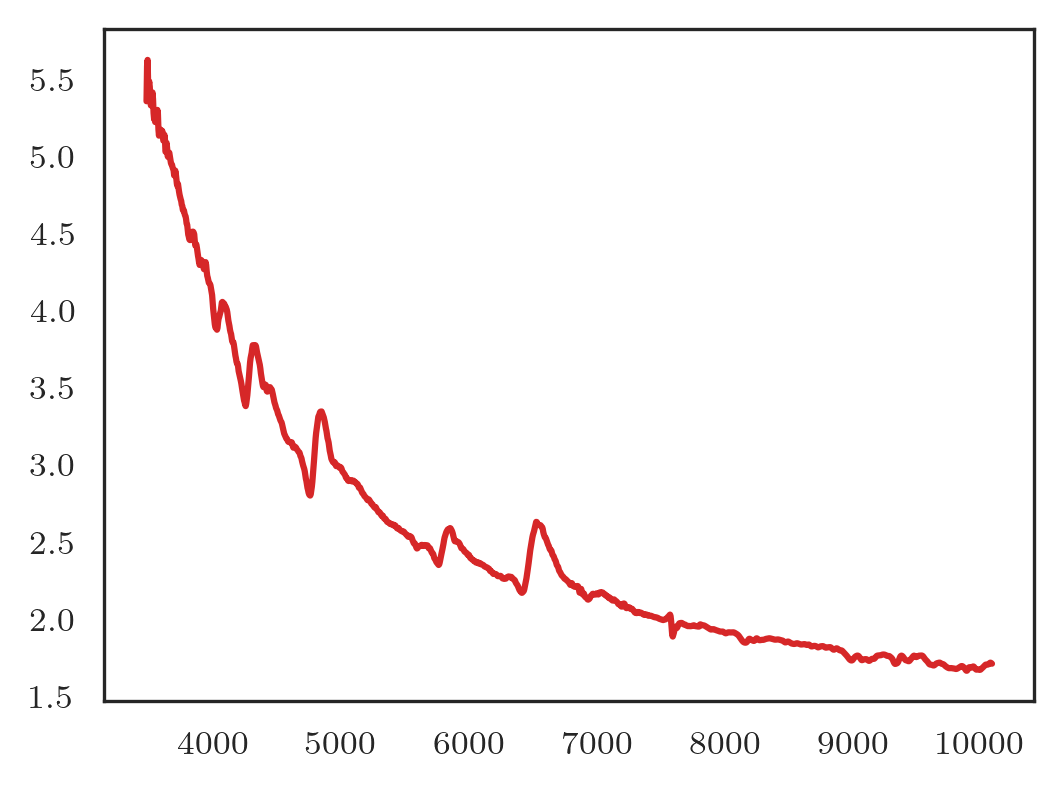

In [6]:
plt.figure(figsize=(base_width, 1.2*base_height), dpi=dpi)
# plt.figure(figsize=())
ax1 = plt.subplot(111)
cols = ["C1", "C7", "k", "k"]
# cols = [":", "--", "-.", "-"]

lines = [
    (r"$\rm{H\alpha}$", 6562.8, 0),
    (r"$\rm{H\beta}$", 4861, 0),
    (r"$\rm{H\gamma}$", 4340, 0)
]

plt.plot(comp["wl"]/comp_redshift, comp["flux"]/np.mean(comp["flux"]) + 1.5, color="C3",label="SN2005cs (template IIP)")
plt.plot(data["wl"]/redshift, data["flux"]/np.mean(data["flux"]) + 0.5, linewidth=0.5, color="C0", alpha=0.5)
plt.plot(swl/redshift, sf/np.mean(sf) + 0.5, color="C7", label="SN2020lam (smoothed)")
plt.legend()

for (label, wl, col) in lines:
    plt.axvline(wl, linestyle=":", color=cols[col])
    
    bbox = dict(boxstyle="round", fc="white", ec=cols[col])
    
    plt.annotate(label, (wl + 40., 0.8 + 0.9*col), fontsize=big_fontsize, bbox=bbox, color=cols[col])

plt.ylabel(r"$F_{\lambda}$ [Arbitrary Units]", fontsize=big_fontsize)
ax1b = ax1.twiny()
ax1.set_xlim(left=3500, right=8000)
rslim = ax1.get_xlim()
ax1b.set_xlim((rslim[0] * redshift, rslim[1] * redshift))
ax1.set_xlabel(r"Rest Wavelength ($\rm \AA$)", fontsize=big_fontsize)
ax1b.set_xlabel(rf"Observed Wavelength (z={redshift-1.:.3f})", fontsize=big_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=big_fontsize)
ax1b.tick_params(axis='both', which='major', labelsize=big_fontsize)
plt.tight_layout()
# sns.despine(right=True, top=False)

filename = "sn2020lam_spectrum.pdf"

output_path = os.path.join(output_folder, f"{filename}")

plt.savefig(os.path.join(plot_dir, filename))
plt.savefig(output_path)

In [ ]:
def load_spectrum(path):
    
    if ".fits" in path:
        raw = Table.read(os.path.join(data_dir, path), format='fits')
        data = raw.to_pandas()
        
        if not "wl" in data.columns:
            if "loglam" in data.columns:
                data.insert(1, "wl", 10.**data["loglam"])
        
    else:
        data = pd.read_table(os.path.join(data_dir, path), names=["wl", "flux"], sep="\s+", comment='#')
    
    return data



def plot_spectrum(
    source_spectrum: tuple,
    comparison_spectrum: tuple = None,
    host_spectrum: tuple = None,
    smooth: int = 12
):
    source_path, source_redshift, source_label = source_spectrum
    
    data = load_spectrum(source_path)
    
    mask = data["flux"] > 0.
    data["flux"][~mask] = 0.00
    
    f = np.array(list(data["flux"]))
    sf = np.zeros(len(f) - smooth)
    swl = np.zeros(len(f) - smooth)

    for i in range(smooth):
        sf += np.array(list(f)[i:-smooth+i])
        swl += np.array(list(data["wl"])[i:-smooth+i])

    sf /= float(smooth)
    swl /= float(smooth)
    
    plt.figure(figsize=(base_width, 1.2*base_height), dpi=dpi)
    ax1 = plt.subplot(111)
    cols = ["C1", "C7", "k", "k"]
    
    if comparison_spectrum is not None:
        comp_path, comp_redshift, comp_label = comparison_spectrum
        comp = load_spectrum(comp_path)
        plt.plot(comp["wl"]/(comp_redshift + 1.), comp["flux"]/np.mean(comp["flux"]) + 1.5, color="C3",label=comp_label)
        
    if host_spectrum is not None:
        host_path, host_redshift, host_label = host_spectrum
        host = load_spectrum(host_path)
        plt.plot(host["wl"]/(host_redshift + 1.), host["flux"]/np.mean(host["flux"]) + 1.5, color="C2",label=host_label)

    plt.plot(data["wl"]/(source_redshift + 1.), data["flux"]/np.mean(data["flux"]) + 0.5, linewidth=0.5, color="C0", alpha=0.5)
    plt.plot(swl/(source_redshift + 1.), sf/np.mean(sf) + 0.5, color="C7", label=f"{source_label} (smoothed)")
    
    plt.legend()
    
    lines = [
        (r"$\rm{H\alpha}$", 6562.8, 0),
        (r"$\rm{H\beta}$", 4861, 0),
        (r"$\rm{H\gamma}$", 4340, 0)
    ]

    for (label, wl, col) in lines:
        plt.axvline(wl, linestyle=":", color=cols[col])

        bbox = dict(boxstyle="round", fc="white", ec=cols[col])

        plt.annotate(label, (wl + 40., 0.8 + 0.9*col), fontsize=big_fontsize, bbox=bbox, color=cols[col])

    plt.ylabel(r"$F_{\lambda}$ [Arbitrary Units]", fontsize=big_fontsize)
    ax1b = ax1.twiny()
    ax1.set_xlim(left=3500, right=8000)
    rslim = ax1.get_xlim()
    ax1b.set_xlim((rslim[0] * redshift, rslim[1] * redshift))
    ax1.set_xlabel(r"Rest Wavelength ($\rm \AA$)", fontsize=big_fontsize)
    ax1b.set_xlabel(fr"Observed Wavelength (z={source_redshift:.3f})", fontsize=big_fontsize)
    ax1.tick_params(axis='both', which='major', labelsize=big_fontsize)
    ax1b.tick_params(axis='both', which='major', labelsize=big_fontsize)
    plt.tight_layout()

    filename = f"{source_label}_spectrum.pdf"

    output_path = os.path.join(output_folder, f"{filename}")
    plt.savefig(os.path.join(plot_dir, filename))
    plt.savefig(output_path)


source_spectrum = ("ZTF20abbpkpa_20200606_NOT_v1.ascii", 0.033, "SN2020lam")
comparison_spectrum = ('2005cs_2005-07-02_00-00-00_Ekar_AFOSC_None.dat', 0.002, "SN2005cs (template IIP)")
host_spectrum = ("spec-0391-51782-0220.fits", 0.033, "Host")


plot_spectrum(source_spectrum, comparison_spectrum=comparison_spectrum, host_spectrum=host_spectrum)

In [ ]:
photometry = pd.read_csv("ZTF20abbpkpa.csv", sep=",")

det_mask = photometry["magpsf"] != 99.
obs = photometry[det_mask]
lim = photometry[~det_mask]

plt.figure(figsize=(base_width, base_height), dpi=dpi)
ax = plt.subplot(111)
ax1b = ax.twinx()

cmap = {
    "g": "g",
    "r": "r",
    "i": "orange"
}


wl = {
    "g": 472.27,
    "r": 633.96,
    "i": 788.61,
}

alpha=0.3

for f in ["g", "r", "i"]:
    
    mask = obs["filter"] == f
    
    if np.sum(mask) > 0:
    
        df = obs[mask]
        ax.errorbar(df["jdobs"]-2400000.5, df["magpsf"], color=cmap[f], yerr=df["sigmamagpsf"], marker="o", linestyle=" ", label=f'{f[-1]} ({wl[f]:.0f} nm)')
        ax1b.errorbar(df["jdobs"]-2400000.5, df["absmag"], color=cmap[f], yerr=df["sigmamagpsf"], marker="o", linestyle=" ")

        delta = np.mean(df["magpsf"] - df["absmag"])

        ldf = lim[lim["filter"] == f]
        ax.errorbar(ldf["jdobs"]-2400000.5, ldf["limmag"], color=cmap[f], linestyle=" ", uplims=True, alpha=alpha)
        ax1b.errorbar(ldf["jdobs"]-2400000.5, ldf["limmag"] - delta, color=cmap[f], linestyle=" ", uplims=True, marker="v", alpha=alpha)

ax.invert_yaxis()
ax1b.invert_yaxis()
ax.set_ylabel(r"Apparent Magnitude", fontsize=big_fontsize)
ax1b.set_ylabel(rf"Absolute Magnitude (z={redshift-1.:.3f})", fontsize=big_fontsize)
ax.tick_params(axis='both', which='major', labelsize=big_fontsize)
ax1b.tick_params(axis='both', which='major', labelsize=big_fontsize)
ax.set_xlabel("Date (MJD)", fontsize=big_fontsize)

t_neutrino = Time("2020-05-30T23:03:55.56", format='isot', scale='utc')

ax.axvline(t_neutrino.mjd, linestyle=":", label="IC200530A")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22),
          ncol=4, fancybox=True, fontsize=big_fontsize)

filename = "sn2020lam_lightcurve.pdf"

output_path = os.path.join(output_folder, f"{filename}")

plt.savefig(os.path.join(plot_dir, filename))
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

# plt.yscale("log")

In [ ]:
def plot_alert_photometry(
    source_name: str,
    nu_name: list = None,
    source_redshift: float = None,
    plot_mag: bool = False,
    public_folder: str = None
):

    photometry = pd.read_csv(os.path.join(data_dir, f"{source_name}.csv"), sep=",")

    det_mask = photometry["magpsf"] != 99.
    obs = photometry[det_mask]
    lim = photometry[~det_mask]

    plt.figure(figsize=(base_width, base_height), dpi=dpi)
    ax = plt.subplot(111)
    ax1b = ax.twinx()

    cmap = {
        "g": "g",
        "r": "r",
        "i": "orange"
    }


    wl = {
        "g": 472.27,
        "r": 633.96,
        "i": 788.61,
    }

    alpha=0.3

    for f in ["g", "r", "i"]:

        mask = obs["filter"] == f

        if np.sum(mask) > 0:

            df = obs[mask]
            ax.errorbar(df["jdobs"]-2400000.5, df["magpsf"], color=cmap[f], yerr=df["sigmamagpsf"], marker="o", linestyle=" ", label=f'{f[-1]} ({wl[f]:.0f} nm)')
            ax1b.errorbar(df["jdobs"]-2400000.5, df["absmag"], color=cmap[f], yerr=df["sigmamagpsf"], marker="o", linestyle=" ")

            delta = np.mean(df["magpsf"] - df["absmag"])

            ldf = lim[lim["filter"] == f]
            ax.errorbar(ldf["jdobs"]-2400000.5, ldf["limmag"], color=cmap[f], linestyle=" ", uplims=True, alpha=alpha)
            ax1b.errorbar(ldf["jdobs"]-2400000.5, ldf["limmag"] - delta, color=cmap[f], linestyle=" ", uplims=True, marker="v", alpha=alpha)

    ax.invert_yaxis()
    ax1b.invert_yaxis()
    ax.set_ylabel(r"Apparent Magnitude", fontsize=big_fontsize)
    ax1b.set_ylabel(rf"Absolute Magnitude (z={redshift-1.:.3f})", fontsize=big_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=big_fontsize)
    ax1b.tick_params(axis='both', which='major', labelsize=big_fontsize)
    ax.set_xlabel("Date (MJD)", fontsize=big_fontsize)

    t_neutrino = Time("2020-05-30T23:03:55.56", format='isot', scale='utc')

    ax.axvline(t_neutrino.mjd, linestyle=":", label="IC200530A")

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22),
              ncol=4, fancybox=True, fontsize=big_fontsize)

    filename = f"{source_name}_lightcurve.pdf"

    output_path = os.path.join(output_folder, f"{filename}")

    plt.savefig(os.path.join(plot_dir, filename))
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    
plot_alert_photometry("ZTF20abbpkpa")